In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-prices/test_copy.csv
/kaggle/input/housing-prices/train_copy.csv


In [62]:
!pip install -q -U keras-tuner


In [63]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt

In [64]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 200000])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

In [65]:
training_data = pd.DataFrame(
            pd.read_csv("/kaggle/input/housing-prices/train_copy.csv")).sample(frac=0.8, random_state=0)
train_data = training_data.copy()
train_data_labels = train_data.pop('SalePrice')
test_data = pd.DataFrame(
            pd.read_csv("/kaggle/input/test-prices/test_copy.csv"))
test_labels = test_data.pop('SalePrice')

def normalizer():
    # data = self.clean_data(False)
    #train_data = train_data.transpose()
    normalizer = layers.Normalization(axis=-1)
    normalizer = layers.Normalization()
    normalizer.adapt(train_data.to_numpy())
    
    print(normalizer.mean.numpy())
    return normalizer

def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten())

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=16)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(8))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_absolute_error',
                metrics=['accuracy'])

  return model

# def build_dnn_model(norm) -> keras.Sequential:
#     model = keras.Sequential([
#         norm,
#         layers.Dense(64, activation='relu'),
#         layers.Dense(64, activation='relu'),
#         layers.Dense(64, activation='relu'),
#         layers.Dense(1)
#     ])

#     model.compile(loss='mean_absolute_error',
#                   optimizer=tf.keras.optimizers.Adam(0.001))

#     return model

# def dnn_model():
#     dnn_model = build_dnn_model(normalizer())
#     dnn_model.summary()
#     history = dnn_model.fit(
#         train_data,
#         train_data_labels,
#         validation_split=0.2,
#         verbose=0, epochs=10000)
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch
#     print(hist.tail(10))

#     plot_loss(history)
#     test_results = dnn_model.evaluate(test_data, test_labels, verbose=0)
#     print(test_results)
    
#     test_predictions = dnn_model.predict(test_data).flatten()
    
    



The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384 and the optimal learning rate for the optimizer
is 0.01.

Best epoch: 1
              loss  accuracy      val_loss  val_accuracy  epoch
1990   9931.369141       0.0  27949.046875           0.0   1990
1991   9260.467773       0.0  27839.603516           0.0   1991
1992   9775.686523       0.0  28070.664062           0.0   1992
1993   9525.729492       0.0  27276.935547           0.0   1993
1994  10778.148438       0.0  31411.078125           0.0   1994
1995  12855.312500       0.0  27858.078125           0.0   1995
1996   9415.742188       0.0  27089.386719           0.0   1996
1997  10333.774414       0.0  27373.650391           0.0   1997
1998  11704.106445       0.0  27951.650391           0.0   1998
1999  10716.215820       0.0  29487.603516           0.0   1999
[16898.919921875, 0.0]


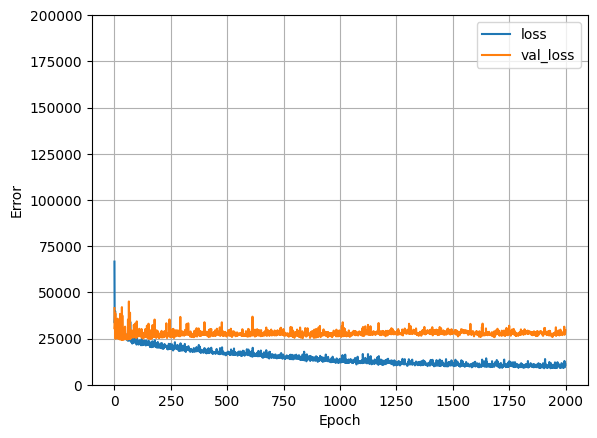

In [66]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=500,
                     factor=5,)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(train_data, train_data_labels, epochs=1000, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(
        train_data,
        train_data_labels,
        validation_split=0.2,
        verbose=0, epochs=2000)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.tail(10))

plot_loss(history)
test_results = model.evaluate(test_data, test_labels, verbose=0)
print(test_results)


# normalizer = normalizer()
# linear_model = tf.keras.Sequential([
#     normalizer,
#     layers.Dense(units=1)
# ])

# linear_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
#     loss='mean_absolute_error')


# history = linear_model.fit(
#     train_data,
#     train_data_labels,
#     epochs=100,
#     # Suppress logging.
#     # Calculate validation results on 20% of the training data.
#     validation_split = 0.2)
# hist = pd.DataFrame(history.history)
# hist['epoch'] = history.epoch
# print(hist)
# plot_loss(history)